In [29]:
# from tqdm import tqdm
import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

from keras import layers

from matplotlib import pyplot as plt
#from matplotlib.ticker import FormatStrFormatter, MultipleLocator

import medmnist

In [5]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [6]:
# CARGAMOS EL DATASET BREASTMNIST

#data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

class TrainingConfig:
    EPOCHS:        int = 50
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001

In [7]:
# SACAMOS LA INFO, COLUMNAS Y CLASES Y ASÍ

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [8]:
print(info)

print("\n'task': 'binary-class', 'label': {'0': 'malignant', '1': 'normal, benign'}, 'n_channels': 1, 'n_samples': {'train': 546, 'val': 78, 'test': 156}'")

{'python_class': 'BreastMNIST', 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1', 'MD5': '750601b1f35ba3300ea97c75c52ff8f6', 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1', 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364', 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1', 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1', 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1', 'MD5_224': 'b5637

In [9]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=TrainingConfig.BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*TrainingConfig.BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*TrainingConfig.BATCH_SIZE, shuffle=False)

In [10]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(val_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: C:\Users\geo_s\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: C:\Users\geo_s\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    M

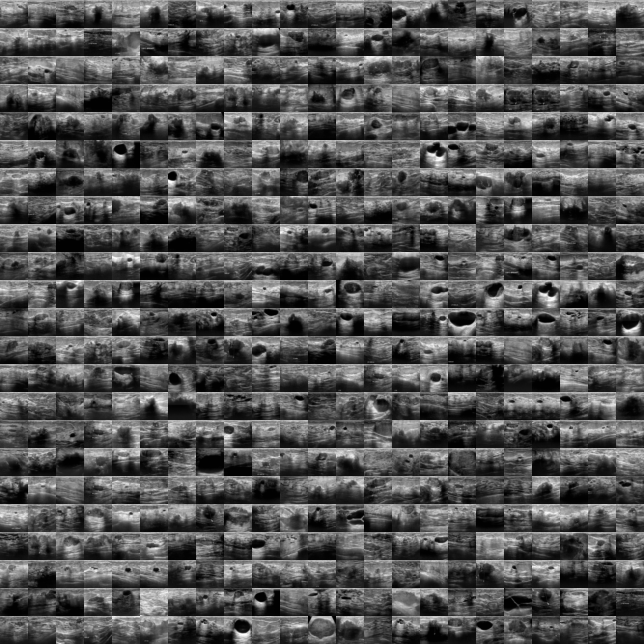

In [11]:
train_dataset.montage(length=23)

In [12]:
data_augmentation = Sequential(
  [
    Input(shape=(28, 28, 1)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(.07),
    layers.RandomZoom(.1)
  ]
)

In [13]:
def build_model(hp):
    model = Sequential(name="modelo_cnn")

    #CANTIDAD DE FILTROS
    hp_filters_1 = hp.Choice('filters_block1', values=[16, 32, 64])
    hp_filters_2 = hp.Choice('filters_block2', values=[16, 32, 64, 128])
    
    #NÚMERO DE NEURONAS EN CAPA DENSA
    hp_units = hp.Int('dense_units', min_value=256, max_value=512, step=128)
    
    #TAZA DE APRENDIZAJE
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    #TAZA DE DROPOUT
    hp_dropout_dense = hp.Float('dropout_dense', min_value=0.2, max_value=0.4, step=0.1)

    #OPTIMIZADORES
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd', 'adagrad'])

    #LLAMAR AL OPTIMIZADOR Y DARLE EL LR
    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    else:
        optimizer = Adagrad(learning_rate=hp_learning_rate)

    #CONSTRUYENDO MODELO
    model.add(data_augmentation)
    model.add(Conv2D(filters=hp_filters_1, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=hp_filters_1, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
    model.add(Dropout(0.25)) 
    
    model.add(Conv2D(filters=hp_filters_2, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=hp_filters_2, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(rate=hp_dropout_dense))
    model.add(Dense(1, activation='sigmoid'))
   
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [14]:
#SINTONIZADOR
tuner = kt.GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,  #NUM DE CONFIGURACIONES DIFERENTES
    executions_per_trial=1, #CANT DE VECES QUE SE ENTRENA CADA CONFIG
    directory='keras_tuner_dir',
    project_name='breast_cancer_optimization',
    overwrite=True
)

In [15]:
tuner.search_space_summary()
stop_early = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
reduce_lr = ReduceLROnPlateau( monitor = 'val_loss', factor = 0.1, patience = 8, min_lr = 0.00001, verbose = 2, mode='min' )

Search space summary
Default search space size: 6
filters_block1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
filters_block2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_dense (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd', 'adagrad'], 'ordered': False}


In [16]:
# SEPARAMOS LABELS DE LAS IMAGENES

X_train = train_dataset.imgs
y_train = train_dataset.labels

X_val = val_dataset.imgs
y_val = val_dataset.labels

X_test = test_dataset.imgs
y_test = test_dataset.labels

In [17]:
print(y_train.shape, X_train.shape)
print("===================")
print(y_val.shape, X_val.shape)
print("===================")
print(y_test.shape, X_test.shape)

(546, 1) (546, 28, 28)
(78, 1) (78, 28, 28)
(156, 1) (156, 28, 28)


In [18]:
#AJUSTAMOS TAMAÑO PARA QUE TENGA LOS REQUISITOS QUE PIDE EL MODELO
X_train_expanded = np.expand_dims(X_train, -1)  #(546, 28, 28, 1) 
X_val_expanded = np.expand_dims(X_val, -1) #(78, 28, 28, 1) 
X_test_expanded = np.expand_dims(X_test, -1) #(156, 28, 28, 1) 

# y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

print(X_train_expanded.shape, y_train.shape)
print("===================")
print(X_val_expanded.shape, y_val.shape)
print("===================")
print(X_test_expanded.shape, y_test.shape)

(546, 28, 28, 1) (546, 1)
(78, 28, 28, 1) (78, 1)
(156, 28, 28, 1) (156, 1)


In [19]:
print("Se inicia la búsqueda de los mejores hp")
hist = tuner.search(X_train_expanded,
             y_train,
             epochs=TrainingConfig.EPOCHS,
             validation_data=(X_val, y_val),
             callbacks=[reduce_lr, stop_early]
            )

Trial 100 Complete [00h 00m 13s]
val_accuracy: 0.7435897588729858

Best val_accuracy So Far: 0.9230769276618958
Total elapsed time: 00h 27m 04s


In [20]:
#OBTENEMOS LOS MEJORES HIPERPARAMETROS
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [21]:
print(f"""
Los mejores hiperparámetros son:
- Filtros Bloque 1: {best_hps.get('filters_block1')}
- Filtros Bloque 2: {best_hps.get('filters_block2')}
- Unidades Densas: {best_hps.get('dense_units')}
- Tasa de Aprendizaje: {best_hps.get('learning_rate')}
- Tasa de Dropout: {best_hps.get('dropout_dense'):.2f}
""")


Los mejores hiperparámetros son:
- Filtros Bloque 1: 16
- Filtros Bloque 2: 16
- Unidades Densas: 256
- Tasa de Aprendizaje: 0.001
- Tasa de Dropout: 0.30



In [22]:
#ARMAMOS EL MODELO CON LOS MEJORES HP
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

c:\Users\geo_s\Documents\MICAI 2025\MedMNIST\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "modelo_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,337 (813.82 KB)

 Trainable params: 208,337 (813.82 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#GUARDAMOS EL MODELO
#best_model.save('modelo_cancer_mama_final.keras')
#best_model.save('modelo_cancer_mama2.keras')
#best_model.save('modelo_data_augmentation.keras') ##EL MEJOR HASTA AHORA
best_model.save('modelo_data_augmentation2.keras')

#PARA CARGARLO
# from tensorflow.keras.models import load_model
# loaded_model = load_model('modelo_data_augmentation.keras')

In [24]:
#ENTRENAMOS
historial = best_model.fit(
    X_train_expanded,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[stop_early, reduce_lr]
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8059 - loss: 0.5110 - val_accuracy: 0.8718 - val_loss: 0.3556 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8187 - loss: 0.4464 - val_accuracy: 0.8974 - val_loss: 0.3372 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8095 - loss: 0.4341 - val_accuracy: 0.8718 - val_loss: 0.3756 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7857 - loss: 0.4747 - val_accuracy: 0.8718 - val_loss: 0.3610 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8242 - loss: 0.4078 - val_accuracy: 0.8205 - val_loss: 0.5810 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 120s 7s/step - accuracy: 0.8205 - loss: 0.4079 - val_accuracy: 0.8462 - val_loss: 0.4070 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7912 - loss: 0.4450 - val_acc

## Gráficas

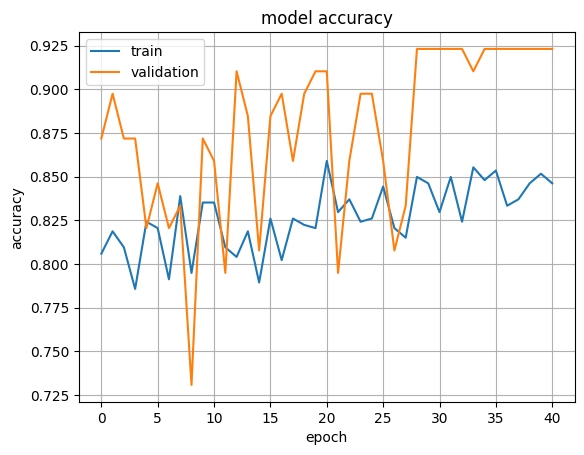

In [30]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    #plt.ylim((0,1))
    plt.grid()
    plt.show()

plot_hist(historial)

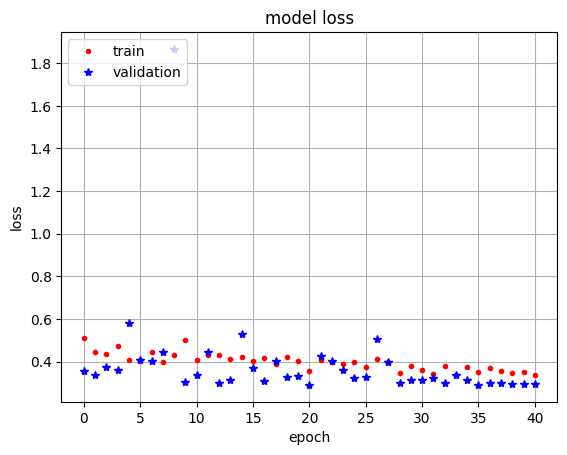

In [31]:
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"],'.r')
    plt.plot(hist.history["val_loss"],'*b')
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    #plt.ylim((0,1))
    plt.grid()
    plt.show()

plot_hist_loss(historial)

In [32]:
best_model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8526 - loss: 0.3941 


[0.39409324526786804, 0.8525640964508057]

In [89]:
prediccion_test = best_model.predict(X_test_expanded)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [90]:
unique_elements, count_elements = np.unique(np.round(prediccion_test),return_counts=True)
print(unique_elements)
print(count_elements)

[0. 1.]
[ 23 133]


In [91]:
prediccion_test=prediccion_test.ravel()

In [92]:
pred_test = np.zeros(X_test.shape[0])

# for id in range(X_test_expanded.shape[0]):
#     pred_test[id] = np.round( prediccion_test[id] )

pred_test = (prediccion_test > 0.8).astype("int32") #SOLO SI ESTÁ 80% SEGURO DE SER NO MALIGNO, LO CLASIFICA COMO TAL

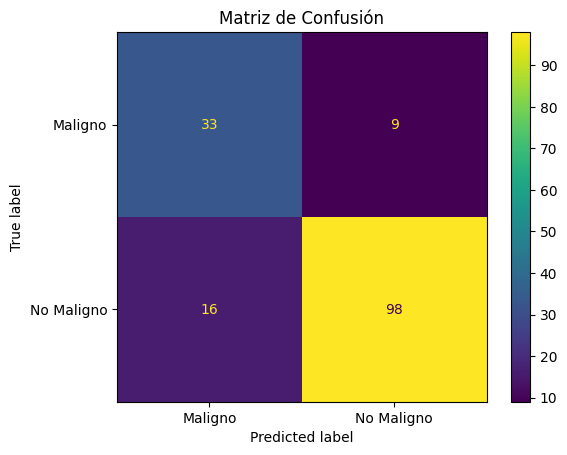

In [ ]:
con = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix = con, display_labels=['Maligno', 'No Maligno'])
disp.plot()
plt.title('Matriz de Confusión')
plt.show()

In [94]:
#CALCULAMOS LOS VALORES DE RENDIMIENTO EN EL ENTRENAMIENTO
final_loss = historial.history['loss'][-1]
final_accuracy = historial.history['accuracy'][-1]
final_val_loss = historial.history['val_loss'][-1]
final_val_accuracy = historial.history['val_accuracy'][-1]

print(f"Resultado Final del Entrenamiento:")
print(f"  - Pérdida de Entrenamiento (Loss): {final_loss:.4f}")
print(f"  - Precisión de Entrenamiento (Accuracy): {final_accuracy:.4f}")
print(f"  - Pérdida de Validación (Validation Loss): {final_val_loss:.4f}")
print(f"  - Precisión de Validación (Validation Accuracy): {final_val_accuracy:.4f}")

Resultado Final del Entrenamiento:
  - Pérdida de Entrenamiento (Loss): 0.3363
  - Precisión de Entrenamiento (Accuracy): 0.8462
  - Pérdida de Validación (Validation Loss): 0.2932
  - Precisión de Validación (Validation Accuracy): 0.9231


In [95]:
#EVALUAMOS EL RENDIMIENTO DEL MODELO CON TEST
print("Evaluando el modelo final con Test")
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print(f"\nResultados Finales en el Test Set:")
print(f"  - Pérdida (Loss): {test_loss:.4f}")
print(f"  - Precisión (Accuracy): {test_accuracy:.4f}")

Evaluando el modelo final con Test
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8526 - loss: 0.3941 

Resultados Finales en el Test Set:
  - Pérdida (Loss): 0.3941
  - Precisión (Accuracy): 0.8526


In [96]:
f1 = f1_score(y_test, pred_test)
print(f"F1_score: {f1}")

F1_score: 0.8868778280542986


### Resultado de la versión 1

Resultado Final del Entrenamiento:
  - Pérdida de Entrenamiento (Loss): 0.1904
  - Precisión de Entrenamiento (Accuracy): 0.9346
  - Pérdida de Validación (Validation Loss): 0.4545
  - Precisión de Validación (Validation Accuracy): 0.7866

### Resultado de la versión 2 

Se añadieron las capas de output para arreglar el sobreajuste.

Resultado Final del Entrenamiento:
  - Pérdida de Entrenamiento (Loss): 0.5360
  - Precisión de Entrenamiento (Accuracy): 0.7408
  - Pérdida de Validación (Validation Loss): 0.5447
  - Precisión de Validación (Validation Accuracy): 0.7439

### Resultado de la versión 3

Integré el Keras Tuner para buscar los mejores hiperparámetros, agregué más evaluaciones y la matriz de confusión. También agregué la evaluación real con el dataset de test. En resumen: muchos cambios :)

Resultado Final del Entrenamiento:
  - Pérdida de Entrenamiento (Loss): 0.0337
  - Precisión de Entrenamiento (Accuracy): 0.9835 *(hay un poco de sobreajuste)*
  - Pérdida de Validación (Validation Loss): 0.7607 
  - Precisión de Validación (Validation Accuracy): 0.9103

Resultados Finales en el Test Set:
  - Pérdida (Loss): 1.1189
  - Precisión (Accuracy): 0.8590

#### Resultado de la version 3.5

Se integraron los cambios recomendados por Edelmira, cambios en el learning rate, se implementó otro callback, se modificaron las capas y las neuronas. 

Resultado Final del Entrenamiento:
  - Pérdida de Entrenamiento (Loss): 0.0442
  - Precisión de Entrenamiento (Accuracy): 0.9872
  - Pérdida de Validación (Validation Loss): 0.3741
  - Precisión de Validación (Validation Accuracy): 0.9359

Resultados Finales en el Test Set:
  - Pérdida (Loss): 0.7562
  - Precisión (Accuracy): 0.8974

### Resultado de la versión 4

Implementé Data augmentation, cambié varios parámetros tanto del modelo cómo de las predicciones.Ya es casi perfecto, está clasificando 10 incorrectas en promedion para cada lado.

Resultado Final del Entrenamiento:
  - Pérdida de Entrenamiento (Loss): 0.3508
  - Precisión de Entrenamiento (Accuracy): 0.8516
  - Pérdida de Validación (Validation Loss): 0.3509
  - Precisión de Validación (Validation Accuracy): 0.8974

Resultados Finales en el Test Set:
  - Pérdida (Loss): 0.3998
  - Precisión (Accuracy): 0.8654

# ----------------------------------------------------------------


# ESTO AÚN NO ESTÁ LISTO!!! ↓↓↓

In [ ]:
# class Net(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super(Net, self).__init__()

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels, 16, kernel_size=3),
#             nn.BatchNorm2d(16),
#             nn.ReLU())

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 16, kernel_size=3),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(16, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
        
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU())

#         self.layer5 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         self.fc = nn.Sequential(
#             nn.Linear(64 * 4 * 4, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, num_classes))

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

In [ ]:
# model = Net(in_channels=n_channels, num_classes=n_classes)

# if task == "multi-label, binary-class":
#     criterion = nn.BCEWithLogitsLoss()
# else:
#     criterion = nn.CrossEntropyLoss()
    
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [25]:
# from matplotlib import pyplot as plt
# from matplotlib.ticker import FormatStrFormatter, MultipleLocator

# def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
     
#     fig, ax = plt.subplots(figsize=(15, 4))
 
#     if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
#         metrics = [metrics,]
#         metric_name = [metric_name,]
         
#     for idx, metric in enumerate(metrics):    
#         ax.plot(metric, color=color[idx])
     
#     plt.xlabel("Epoch")
#     plt.ylabel(ylabel)
#     plt.title(title)
#     plt.xlim([0, TrainingConfig.EPOCHS-1])
#     plt.ylim(ylim)
#     # Tailor x-axis tick marks
#     ax.xaxis.set_major_locator(MultipleLocator(5))
#     ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#     ax.xaxis.set_minor_locator(MultipleLocator(1))
#     plt.grid(True)
#     plt.legend(metric_name)   
#     plt.show()
#     plt.close()

In [26]:
# train_loss = historial.history["loss"]
# train_acc  = historial.history["accuracy"]
# valid_loss = historial.history["val_loss"]
# valid_acc  = historial.history["val_accuracy"]
   
# plot_results([ train_loss, valid_loss ],        
#             ylabel="Loss", 
#             #ylim = [0.0, 5.0],
#             metric_name=["Training Loss", "Validation Loss"],
#             color=["g", "b"]);
 
# plot_results([ train_acc, valid_acc ], 
#             ylabel="Accuracy",
#             #ylim = [0.0, 1.0],
#             metric_name=["Training Accuracy", "Validation Accuracy"],
#             color=["g", "b"])

In [ ]:
# for epoch in range(TrainingConfig.NUM_EPOCHS):
#     train_correct = 0
#     train_total = 0
#     test_correct = 0
#     test_total = 0
    
#     model.train()
#     for inputs, targets in tqdm(train_loader):
#         # forward + backward + optimize
#         optimizer.zero_grad()
#         outputs = model(inputs)
        
#         if task == 'multi-label, binary-class':
#             targets = targets.to(torch.float32)
#             loss = criterion(outputs, targets)
#         else:
#             targets = targets.squeeze().long()
#             loss = criterion(outputs, targets)
        
#         loss.backward()
#         optimizer.step()

In [ ]:
# from medmnist import Evaluator

# def test(split):
#     model.eval()
#     y_true = torch.tensor([])
#     y_score = torch.tensor([])
    
#     data_loader = train_loader_at_eval if split == 'train' else test_loader

#     with torch.no_grad():
#         for inputs, targets in data_loader:
#             outputs = model(inputs)

#             if task == 'multi-label, binary-class':
#                 targets = targets.to(torch.float32)
#                 outputs = outputs.softmax(dim=-1)
#             else:
#                 targets = targets.squeeze().long()
#                 outputs = outputs.softmax(dim=-1)
#                 targets = targets.float().resize_(len(targets), 1)

#             y_true = torch.cat((y_true, targets), 0)
#             y_score = torch.cat((y_score, outputs), 0)

#         y_true = y_true.numpy()
#         y_score = y_score.detach().numpy()
        
#         evaluator = Evaluator(data_flag, split)
#         metrics = evaluator.evaluate(y_score)
    
#         print('%s  auc: %.3f  acc:%.3f' % (split, *metrics)) 

In [ ]:
# print('==> Evaluating ...')
# test('train')
# test('test')

In [ ]:
# def build_model(hp):
#     model = Sequential()
#     model.add( Input(  shape=(X_train_robustscaler.shape[1],)) )

#     for i in range(hp.Int("num_layers", 1, 2)):  # Tune the number of layers.
#         model.add(
#             Dense(
#                 units      = hp.Int   (f'units_{i}', min_value=1, max_value=25, step=2 ), # <--- [1..15]
#                 activation = hp.Choice(f"activation_{i}", ["relu", "selu","leaky_relu"]),
#             )
#         )

#     model.add( Dense( 1, activation = 'sigmoid', name = "predictions" ) ) # <---- capa de salida

#     lr = hp.Choice( 'lr', values=[1e-2, 1e-3, 1e-4] )
#     optimizers_dict = {
#        "Adam":    keras.optimizers.Adam(learning_rate=lr),
#         "SGD":     keras.optimizers.SGD(learning_rate=lr),
#         "Adagrad": keras.optimizers.Adagrad(learning_rate=lr)
#         }

#     hp_optimizers = hp.Choice(
#         'optimizer',
#         values=[ "SGD", "Adam", "Adagrad"]
#         )

#     model.compile( optimizer    = optimizers_dict[hp_optimizers],
#                     loss      = "binary_crossentropy",
#                     metrics   = ['accuracy']
#                     )

#     return model

In [ ]:
# # PROTOTIPO DE MODELO HELP 
# # AL FINAL ES SIGMOIDE DUH

# def cnn_model(input_shape=(28, 28, 1)):
     
#     model = Sequential()
     
#     #------------------------------------
#     # Conv Block 1: 32 Filters, MaxPool.
#     #------------------------------------
#     model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
#     model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25)) #AGREGUE LAYERS DE OUTPUT PARA REDUCIR EL SOBREAJUSTE
 
#     #------------------------------------
#     # Conv Block 2: 64 Filters, MaxPool.
#     #------------------------------------
#     model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
#     model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
 
#     #------------------------------------
#     # Conv Block 3: 64 Filters, MaxPool.
#     #------------------------------------
#     model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
#     model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25)) 
     
#     #------------------------------------
#     # Flatten the convolutional features.
#     #------------------------------------
#     model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5)) #Dropout más denso para el final
#     model.add(Dense(1, activation='sigmoid'))
     
#     return model